In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
from altimetry_tools import velocity, Filter, filterSpec1, Laplacian1D
from tqdm.notebook import tqdm
import xarray as xr
import warnings 
warnings.filterwarnings('ignore')

x4 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/bathymetry_gebco_2020/coastlines_global.nc')  

In [2]:
# procedure
# - define lat/lon box
# - determine which tracks fall within box 
# - for estimated two tracks, take each cycle and add random error of listed magnitude 
# (random error generated once for each cycle and added once to each cycle...)
# (...but because we have a few hundred cycles, a normal distribution of error will be added in total)
# (OR for each cycle add randomly generated error 200 times and, propagate error)
# (...take mean at each month across all appropriate time points FOR each of the 200 iterations of added error)
# (... look at std of each of those 200 means)
# - calculate velocity
# - filter to all filter scales 
# - make annual mean time series of EKE as a function of scale 

In [2]:
# load obs. 
this_sat = 'j2'
load_sat = pickle.load(open('/Users/jakesteinberg/Documents/CPT/altimetry/' + \
                            this_sat + '_' + 'processed_adt_x20_short.p', 'rb'))
dist = load_sat['dist']
adt = load_sat['adt']
lon_record = load_sat['lon_record']
lat_record = load_sat['lat_record']
track_record = load_sat['track']
time_record = load_sat['time']

In [3]:
# locations used previously 
order = ['Eastern N. Pac.', 'Kuroshio', 'Indian', 'N. Atl.', 'ACC', 'Gulf Stream']
location = np.array([[210, 214, 35, 39], [148, 152, 28, 32], [90, 94, -21, -17], \
                     [326, 330, 38, 42], [310, 314, -52, -48], [290, 294, 30, 34]])

In [4]:
# pick location
l_i = 1

In [5]:
lon_w = 0
lon_e = 360
lat_s = -60
lat_n = 60
# lat/lon key
for i in range(len(lon_record)):
    if i < 1:
        lon_t = lon_record[i]
        lat_t = lat_record[i]
        track_t = np.ones(len(lon_record[i])) * track_record[i]
    else:
        lon_t = np.concatenate((lon_t, lon_record[i]))
        lat_t = np.concatenate((lat_t, lat_record[i]))    
        track_t = np.concatenate((track_t, np.ones(len(lon_record[i])) * track_record[i]))

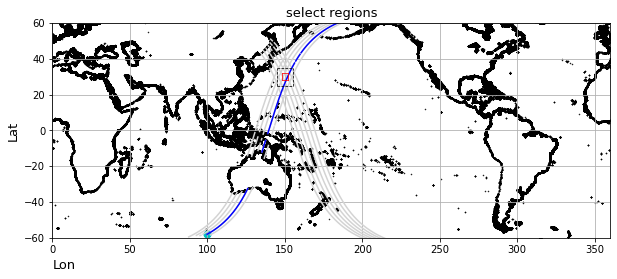

In [6]:
# box center         
this_lon = np.nanmean(location[l_i][0:2])
this_lat = np.nanmean(location[l_i][2:])
# -- units of degrees, size of box to consider tracks 
# -- pick box within which is the box that identifies location of interest 
lon_win = 10
lat_win = lon_win
this_lon0 = this_lon - lon_win/2
this_lon1 = this_lon + lon_win/2
this_lat0 = this_lat - lat_win/2
this_lat1 = this_lat + lat_win/2
        
inn = np.where((lon_t > this_lon0) & (lon_t < this_lon1) & (lat_t > this_lat0) & (lat_t < this_lat1))[0]
# tracks that fall within this box 
[ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True)

f, ax = plt.subplots(1,1,figsize=(10,8))
ax.scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.25)
for tib in range(len(ai)):
    ax.plot(lon_record[ai[tib]], lat_record[ai[tib]], color='#D3D3D3')
ax.plot(lon_record[ai[0]], lat_record[ai[0]], color='b')
ax.scatter(lon_record[ai[0]][0], lat_record[ai[0]][0], s=50, color='c')
ax.plot([this_lon0, this_lon1], [this_lat0, this_lat0], color='k', linestyle='--', linewidth=0.75)
ax.plot([this_lon0, this_lon1], [this_lat1, this_lat1], color='k', linestyle='--', linewidth=0.75)
ax.plot([this_lon0, this_lon0], [this_lat0, this_lat1], color='k', linestyle='--', linewidth=0.75)
ax.plot([this_lon1, this_lon1], [this_lat0, this_lat1], color='k', linestyle='--', linewidth=0.75)
ax.plot([location[l_i][0], location[l_i][1]], [location[l_i][2], location[l_i][2]], color='r', linewidth=0.75)
ax.plot([location[l_i][0], location[l_i][1]], [location[l_i][3], location[l_i][3]], color='r', linewidth=0.75)
ax.plot([location[l_i][0], location[l_i][0]], [location[l_i][2], location[l_i][3]], color='r', linewidth=0.75)
ax.plot([location[l_i][1], location[l_i][1]], [location[l_i][2], location[l_i][3]], color='r', linewidth=0.75)
buffer = 5
ax.set_xlim([this_lon0 - buffer, this_lon1 + buffer])
ax.set_ylim([this_lat0 - buffer, this_lat1 + buffer])
w = 1 / np.cos(np.deg2rad(np.nanmean([this_lat0, this_lat1])))
ax.set_aspect(w)
ax.set_xlim([lon_w, lon_e])
ax.set_ylim([lat_s, lat_n])
ax.set_xlabel('Lon', fontsize=13, horizontalalignment='left', x=0.0)
ax.set_ylabel('Lat', fontsize=13)
ax.set_title('select regions', fontsize=13)
ax.grid()
plt.show()
f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/r2/added_site_errors/j2_sample_monte_carlo_error_nw_pac_key.jpg', dpi=400)

In [7]:
# prep for partitioning into months 
year_day = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]  # days per month 
year_time_record = []
for i in range(len(time_record)):
    t_s = datetime.utcfromtimestamp(time_record[i][0])  # start time 
    offset_i = np.sum(year_day[0:t_s.month - 1])/365 + t_s.day/365 + t_s.hour/(365*24)  # starting time index (fractional days)
    year_time_record.append(((time_record[i] - time_record[i][0])/(60*60*24))/365 + offset_i)

In [8]:
# ai = list of tracks that fall within outer box 
# subset array into only tracks that fall within box and add desired error
j2_noise = 0.011 # m rms 
mc_runs = 250
adt0 = []
adt1 = []
dist1 = []
lon1 = []
lat1 = []
track1 = []
year_time1 = []
for ii in tqdm(range(len(ai))):
    this_track = load_sat['adt'][ai[ii]].copy()
    plus_error = np.nan*np.ones((np.shape(this_track)[0], np.shape(this_track)[1], mc_runs))
    for jj in range(np.shape(this_track)[0]):
        plus_error[jj, :, :] = np.tile(this_track[jj, :][:, None], (1, mc_runs)) + j2_noise*\
            np.random.normal(0,scale=1.0,size=(np.shape(this_track)[1], mc_runs))
    adt0.append(this_track)
    adt1.append(plus_error)
    dist1.append(dist[ai[ii]])
    lat1.append(lat_record[ai[ii]])
    lon1.append(lon_record[ai[ii]])
    track1.append(track_record[ai[ii]])
    year_time1.append(year_time_record[ai[ii]])

In [9]:
print(track1)
np.unique(track_t[inn])

[49.0, 60.0, 75.0, 86.0, 125.0, 136.0, 151.0, 162.0, 212.0, 227.0, 238.0]


array([ 49.,  60.,  75.,  86., 125., 136., 151., 162., 212., 227., 238.])

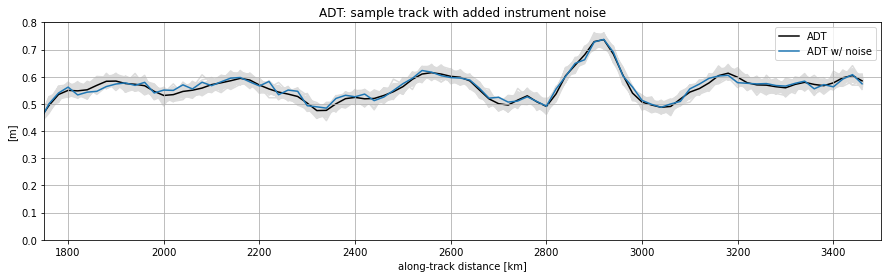

In [11]:
# compare OG and that with added noise 
track_in_i = 0  # select one track from new subset
gid = np.where(track_record == track_record[ai[track_in_i]])[0][0]
pass_i = 5
f, ax = plt.subplots(1,1,figsize=(15,4))
for i in range(mc_runs):
    ax.plot(dist1[track_in_i], adt1[track_in_i][pass_i, :, i], color='#DCDCDC', zorder=0)
ax.plot(dist[gid], adt[gid][pass_i, :], color='k', zorder=1, label='ADT')
ax.plot(dist1[track_in_i], adt1[track_in_i][pass_i, :, 0], label='ADT w/ noise')
ax.set_xlim([1750, 3500])
ax.set_ylim([0, .8])
ax.set_title('ADT: sample track with added instrument noise')
ax.set_xlabel('along-track distance [km]')
ax.set_ylabel('[m]')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
ax.grid()
plt.show()
f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/r2/added_site_errors/j2_sample_monte_carlo_error_nw_pac_track.jpg', dpi=400)

In [12]:
def velocity_mc(dist, sla, lon_record, lat_record, track_record, stencil_width, mc_runs):   
    transition_lat = 5  # latitude to smoothly transition to beta-plane from local f-plane
    vel = []
    vel_f = []
    grad = []
    count = 0
    for m in tqdm(range(len(track_record))):
        # -- load in data for this track 
        sla_grad_mc = np.nan*np.ones(np.shape(sla[m]))
        vel_mc = np.nan*np.ones(np.shape(sla[m]))
        vel_f_mc = np.nan*np.ones(np.shape(sla[m]))
        for mc in range(mc_runs):
            this_sla = sla[m][:, :, mc]            # interpolated field, sla is just a place holder (confusing I know)
            lon_grid = lon_record[m]
            lat_grid = lat_record[m]
            d_grid = dist[m]
        
            grid_space = d_grid[1] - d_grid[0]
            these_cycles = np.arange(0, np.shape(this_sla)[0])                 
            if len(d_grid) < 10:
                print('track ' + str(m) + ', too short') 
                grad.append(np.nan * np.ones(np.shape(this_sla)))
                vel.append(np.nan * np.ones(np.shape(this_sla)))
                continue
            
            # -- gradient ([Arbic 2012]) (pol_rad = 6378.137km) (eq_rad = 6356.752km) 
            f_loc = 2*(7.27*10**(-5))*np.sin(np.deg2rad(lat_grid))    
            sla_grad = np.gradient(this_sla, d_grid*1000.0, axis=1)
            for cdm in range(4, 4 + len(sla_grad[0, 4:-3])):
                # -- gradients from a 7 point stencil 
                if stencil_width == 7:   
                    sla_grad[:, cdm] = (this_sla[:, cdm+3] - 9*this_sla[:, cdm+2] + 45*this_sla[:, cdm+1] - 45*this_sla[:, cdm-1] + 9*this_sla[:, cdm-2] - this_sla[:, cdm-3]) / (60*(grid_space*1000.0))   
                # -- gradients from a 5 point stencil
                elif stencil_width == 5:   
                    sla_grad[:, cdm] = (-this_sla[:, cdm+2] + 8*this_sla[:, cdm+1] - 8*this_sla[:, cdm-1] + this_sla[:, cdm-2]) / (12*(grid_space*1000.0))
                elif stencil_width == 3: 
                    sla_grad[:, cdm] = (this_sla[:, cdm+1] - this_sla[:, cdm-1]) / (2*(grid_space*1000.0))  
                else:
                    print('select either 3,5,7 for gradient stencil_width')
                
            # velocity via geostrophic balance 
            this_vel = (9.81/np.tile(f_loc[None, :], (len(these_cycles), 1))) * sla_grad 
            this_vel_f = this_vel.copy()      
            # -- near equator attempt beta plane correction from [Lagerloef 1999] 
            close_eq1 = np.where(np.abs(lat_grid) < transition_lat)[0]
            if len(close_eq1) > 10:  # if there are points close to equator, make sure there are enough to compute a gradient
                beta = 2*(7.27*10**(-5))*np.cos(np.deg2rad(lat_grid[close_eq1]))/(6356752)
                y = 1852 * 60 * (lat_grid[close_eq1] - 0)  # 6356752*lat_grid[close_eq1]  
                # -- weights transitioning from beta plane to f plane 
                wb = np.exp(-(np.abs(lat_grid[close_eq1])/2.2)**2)
                wf = 1 - wb                       
                # -- geostrophic balance 
                uf = (9.81/(np.tile(f_loc[close_eq1][None, :], (len(these_cycles), 1)))) * sla_grad[:, close_eq1]  
                # -- approximate the along-track distance of d_eta/dx          
                ub = (9.81/(y*np.tile(beta[None, :], (len(these_cycles), 1)))) * sla_grad[:, close_eq1]
                # -- combine uf, wb each scaled by weights 
                ug = np.tile(wb[None, :], (len(these_cycles), 1))*ub + np.tile(wf[None, :], (len(these_cycles), 1))*uf
                this_vel[:, close_eq1] = ug 
        
            sla_grad_mc[:, :, mc] = sla_grad
            vel_mc[:, :, mc] = this_vel
            vel_f_mc[:, :, mc] = this_vel_f
        
        # -- save for each track arrays of fields [cycle X Distance] (each array is an element in a list)
        grad.append(sla_grad_mc)
        vel.append(vel_mc)
        vel_f.append(vel_f_mc)
               
    return grad, vel, vel_f

In [13]:
# VELOCITY (call function, input either adt or sla) 
stencil_width = 3
eta_grad0, vel0, vel_f0 = velocity(dist1, adt0, lon1, lat1, track1, stencil_width)
eta_grad1, vel1, vel_f1 = velocity_mc(dist1, adt1, lon1, lat1, track1, stencil_width, mc_runs)

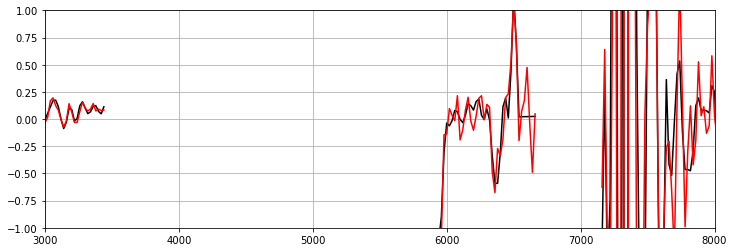

In [14]:
# compare OG and that with added noise 
track_in_i = 0
gid = np.where(track_record == track_record[ai[track_in_i]])[0][0]
pass_i = 3
f, ax = plt.subplots(1,1,figsize=(12,4))
# for i in range(mc_runs):
#     ax.plot(dist1[track_in_i], vel[track_in_i][pass_i, :, i], color='#DCDCDC', zorder=0)
ax.plot(dist1[track_in_i], vel0[track_in_i][pass_i, :],color='k')
ax.plot(dist1[track_in_i], vel1[track_in_i][pass_i, :, 0],color='r')
ax.set_xlim([3000, 8000])
ax.set_ylim([-1, 1])
ax.grid()
plt.show()

In [16]:
# filtering 
hor_grid_spacing = dist1[0][10] - dist1[0][9]
# ******
wavelengths = np.flip(np.array([60, 140, 300]))
# ******
k_sub = 1/wavelengths
coarsening_factors = np.nan * np.ones(len(k_sub))
for i in range(len(k_sub)):
    thisone =  np.round((1/k_sub[i])/hor_grid_spacing)
    print('smoothing to ' + str(thisone*hor_grid_spacing) + ' km')
    coarsening_factors[i] = thisone
coarse_fac = coarsening_factors*hor_grid_spacing
print('filtering factors = ' + str(coarsening_factors) + ' ** = full width of boxcar **')
filter_width = np.nan * np.ones(len(k_sub))
for i in range(len(k_sub)):
    thisone = np.round( (1/k_sub[i])/hor_grid_spacing) 
    filter_width[i] = thisone*hor_grid_spacing
filter_band = filter_width[0:-1] + np.diff(filter_width)/2
filter_band = np.append(filter_band, (filter_width[-1] - hor_grid_spacing)/2 + hor_grid_spacing)
band_centers = filter_band
band_ends = filter_width
print('band ends = ' + str(band_ends))
print('band centers = ' + str(band_centers))

smoothing to 300.0 km
smoothing to 140.0 km
smoothing to 60.0 km
filtering factors = [15.  7.  3.] ** = full width of boxcar **
band ends = [300. 140.  60.]
band centers = [220. 100.  40.]


In [17]:
# SET FILTERING PARAMETERS 
N = 65                     # filter steps (computational choice)
N_G = 20
dx = 1
LfB = coarsening_factors.copy()
LfT = LfB.copy()
LfG = LfB.copy()  # /np.sqrt(6)         # gaussian 

Using default N, N = 68 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 32 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 14 If d>2 or X is not pi then results might not be accurate.



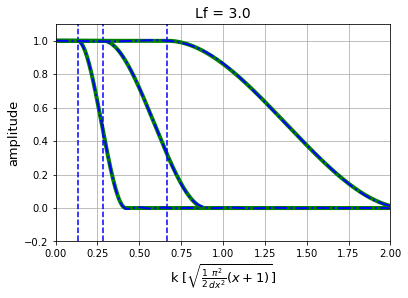

In [18]:
# FILTER velocities with no noise 
vel_filt_0 = []
for i in tqdm(range(len(coarsening_factors))):
    vel_filt_i = Filter('Taper', vel0, dx, LfT[i], plot_filter=1)  # if boxcar--> np.int(LfB[i])
    vel_filt_0.append(vel_filt_i)

Using default N, N = 68 If d>2 or X is not pi then results might not be accurate.



Using default N, N = 32 If d>2 or X is not pi then results might not be accurate.



Using default N, N = 14 If d>2 or X is not pi then results might not be accurate.


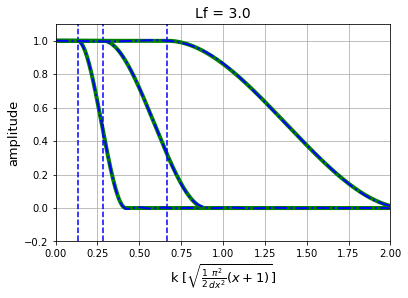

In [19]:
# FILTER 
plot_filter = 1
dxMin = 1
field = vel1.copy()
vel_filt_1 = []
for i in tqdm(range(len(coarsening_factors))):
    p,NL,sL,NB,sB = filterSpec1(dxMin,LfT[i],plot_filter,shape="Taper", X=np.pi)
    # each track  
    sla_filt_cfi = []
    for c in tqdm(range(len(field))):  
        # land = np.where(np.isnan(field[c][0, :, 0]))[0]
        # landMask = np.zeros(np.shape(field[c])[1])
        # landMask[land] = 1
        
        sla_filt = np.nan * np.ones(np.shape(field[c]))
        for mc in range(mc_runs):
            # each cycle
            for m in range(np.shape(field[c])[0]):  
                # data = field[c][m, :, mc].copy()
                
                data = field[c][m, :, mc].copy()
                land = np.where(np.isnan(field[c][m, :]))[0]
                landMask = np.zeros(np.shape(field[c])[1])
                landMask[land] = 1
                wetMask = 1 - landMask
                data = np.nan_to_num(data) 
                data = data * wetMask # Initalize the filtering process           
                
                # tempL_out = np.nan * np.ones((NL, np.shape(field)[0], np.shape(field)[1]))
                for i in range(NL):
                    tempL = Laplacian1D(data,landMask,dx)
                    # tempL_out[i, :, :] = tempL.copy()
                    data = data + (1/sL[i])*tempL # Update filtered field
                for i in range(NB):
                    tempL = Laplacian1D(data, landMask, dx)
                    tempB = Laplacian1D(tempL, landMask, dx)
                    data = data + (2*np.real(sB[i])/(np.abs(sB[i])**2))*tempL + (1/(np.abs(sB[i])**2))*tempB
                sla_filt[m, :, mc] = data
        sla_filt_cfi.append(sla_filt) 
    vel_filt_1.append(sla_filt_cfi)   

In [105]:
# vel_filt_1 = [coarsening_factor][track][cycle, distance, monte_carlo_error]

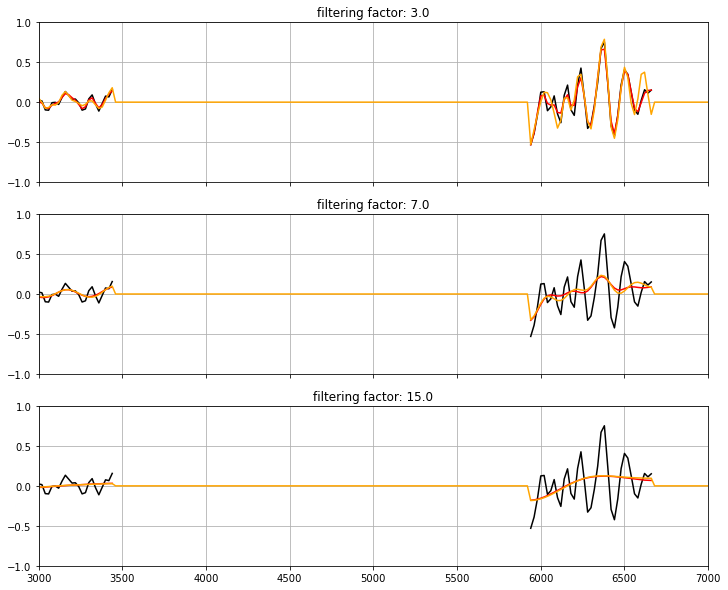

In [20]:
# compare OG and that with added noise 
track_in_i = 0
gid = np.where(track_record == track_record[ai[track_in_i]])[0][0]
pass_i = 10
f, (ax2, ax3, ax4) = plt.subplots(3,1,figsize=(12,10), sharex=True, sharey=True)
ax2.plot(dist1[track_in_i], vel0[track_in_i][pass_i, :],color='k')
ax3.plot(dist1[track_in_i], vel0[track_in_i][pass_i, :],color='k')
ax4.plot(dist1[track_in_i], vel0[track_in_i][pass_i, :],color='k')

ax2.plot(dist1[track_in_i], vel_filt_0[2][track_in_i][pass_i, :],color='r')
ax2.set_title('filtering factor: ' + str(coarsening_factors[2]))
ax3.plot(dist1[track_in_i], vel_filt_0[1][track_in_i][pass_i, :],color='r')
ax3.set_title('filtering factor: ' + str(coarsening_factors[1]))
ax4.plot(dist1[track_in_i], vel_filt_0[0][track_in_i][pass_i, :],color='r')
ax4.set_title('filtering factor: ' + str(coarsening_factors[0]))

ax2.plot(dist1[track_in_i], vel_filt_1[2][track_in_i][pass_i, :, 10], color='#FFA500', label='filtered, noise')
ax3.plot(dist1[track_in_i], vel_filt_1[1][track_in_i][pass_i, :, 10], color='#FFA500', label='filtered, noise')
ax4.plot(dist1[track_in_i], vel_filt_1[0][track_in_i][pass_i, :, 10], color='#FFA500', label='filtered, noise')
ax2.set_xlim([3000, 7000])
ax2.set_ylim([-1.0, 1.0])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
ax.grid()
ax2.grid()
ax3.grid()
ax4.grid()
plt.show()

In [21]:
# lat/lon key (of tracks that fall within large box denoted in first map)
for i in range(len(lon1)):
    if i < 1:
        lon_t = lon1[i]
        lat_t = lat1[i]
        track_t = np.ones(len(lon1[i])) * track1[i]
    else:
        lon_t = np.concatenate((lon_t, lon1[i]))
        lat_t = np.concatenate((lat_t, lat1[i]))    
        track_t = np.concatenate((track_t, np.ones(len(lon1[i])) * track1[i]))

In [22]:
# NON MC RUNS 
# find only data within lat/lon box 
thresh = 25
step = 1
lon_bins = np.arange(location[l_i][0], location[l_i][1] + step, step)
lat_bins = np.arange(location[l_i][2], location[l_i][3] + step, step)
lon_bin_c = lon_bins[0:-1] + np.diff(lon_bins)/2
lat_bin_c = lat_bins[0:-1] + np.diff(lat_bins)/2
lon_win = 4

months = np.concatenate((np.array([0]), (np.cumsum(np.array([year_day])))))/365
s_i = np.concatenate((months[0:-1][:, None], months[1:][:, None]), axis=1) 

mean_sla0 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))
mean_sla_smooth = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))
mean_diff0 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))

for tt in range(len(s_i)):      # each month 
    for i in tqdm(range(1, len(lon_bin_c) - 1)):  # lon
        for j in range(1, len(lat_bin_c) - 1):    # lat
        
            this_lon = lon_bin_c[i]
            this_lat = lat_bin_c[j]     
            this_lon0 = this_lon - lon_win/2
            this_lon1 = this_lon + lon_win/2
            this_lat0 = this_lat - lat_win/2
            this_lat1 = this_lat + lat_win/2
        
            inn = np.where((lon_t > this_lon0) & (lon_t < this_lon1) & (lat_t > this_lat0) & (lat_t < this_lat1))[0]
            # tracks that fall within this box 
            [ci, ai, bi] = np.intersect1d(track1, np.unique(track_t[inn]), return_indices=True)    
            countf = 0
            filters = {}
            for tib in range(len(ai)):  # each track
                # for each track that crosses through box, again find subset of grid points in box 
                inn2 = np.where((lon1[ai[tib]] > this_lon0) & (lon1[ai[tib]] < this_lon1) & \
                                (lat1[ai[tib]] > this_lat0) & (lat1[ai[tib]] < this_lat1) & \
                                (np.abs(lat1[ai[tib]]) > 5))[0]
                # time bin 
                this_time = np.mod(year_time1[ai[tib]], 1)
                time_in = np.where((this_time > s_i[tt, 0]) & (this_time < s_i[tt, 1]))[0]
                # loop over each filter scale (ORDER large to small)   
                if countf < 1:
                    sla_i = vel0[ai[tib]][time_in][:, inn2].flatten()                  # unfiltered velocity (no noise)                  
                    for ff in range(len(coarsening_factors)):  
                        falls_within_0 = vel_filt_0[ff][ai[tib]][time_in][:, inn2]     # [time_in, in_box]      filtered, no noise
                        filters[coarsening_factors[ff]] = falls_within_0.flatten()
                    countf = countf + 1
                else:
                    sla_i = np.append(sla_i, vel0[ai[tib]][time_in][:, inn2].flatten())
                    for ff in range(len(coarsening_factors)):  
                        falls_within_0 = vel_filt_0[ff][ai[tib]][time_in][:, inn2]     # [time_in, in_box]      filtered, no noise
                        filters[coarsening_factors[ff]] = np.concatenate((filters[coarsening_factors[ff]], \
                                                                        falls_within_0.flatten()))
            # average in this lat/lon box 
            if countf > 0:  
                if (len(sla_i) > thresh):
                    # -- unfiltered eddy energy estimate (highest resolution)
                    mean_sla0[tt, i, j] = np.nanmean(sla_i**2)  
                    # ORDER = large to small 
                    for cf in range(len(coarsening_factors)):
                        # -- large scale (\overline{\eta}^2) (filtering of the quantity, then squaring)
                        mean_sla_smooth[tt,i,j,cf] = np.nanmean(filters[coarsening_factors[cf]]**2)
                        # - SHARP -- EKE w/o filtering the squared velocity 
                        mean_diff0[tt,i,j,cf] = np.nanmean(sla_i**2 - filters[coarsening_factors[cf]]**2) 

In [23]:
# average in lat/lon bins for each mc run 
mean_sla1 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))
mean_sla_smooth_mc = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors), mc_runs))
mean_diff0_mc = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors), mc_runs))

for mc in tqdm(range(mc_runs)):           # cycle through monte-carlo run
    for tt in range(len(s_i)):      # each month 
        for i in range(1, len(lon_bin_c) - 1):  # lon
            for j in range(1, len(lat_bin_c) - 1):    # lat
        
                this_lon = lon_bin_c[i]
                this_lat = lat_bin_c[j]     
                this_lon0 = this_lon - lon_win/2
                this_lon1 = this_lon + lon_win/2
                this_lat0 = this_lat - lat_win/2
                this_lat1 = this_lat + lat_win/2
        
                inn = np.where((lon_t > this_lon0) & (lon_t < this_lon1) & (lat_t > this_lat0) & (lat_t < this_lat1))[0]
                # tracks that fall within this box 
                [ci, ai, bi] = np.intersect1d(track1, np.unique(track_t[inn]), return_indices=True)    
                countf = 0
                filters_mc = {}
                for tib in range(len(ai)):  # each track
                    # for each track that crosses through box, again find subset of grid points in box 
                    inn2 = np.where((lon1[ai[tib]] > this_lon0) & (lon1[ai[tib]] < this_lon1) & \
                                    (lat1[ai[tib]] > this_lat0) & (lat1[ai[tib]] < this_lat1) & \
                                    (np.abs(lat1[ai[tib]]) > 5))[0]
                    # time bin 
                    this_time = np.mod(year_time1[ai[tib]], 1)
                    time_in = np.where((this_time > s_i[tt, 0]) & (this_time < s_i[tt, 1]))[0]
                    # loop over each filter scale (ORDER large to small)   
                    if countf < 1:
                        sla_i = vel0[ai[tib]][time_in][:, inn2].flatten()
                        for ff in range(len(coarsening_factors)):  
                            falls_within_1 = vel_filt_1[ff][ai[tib]][time_in][:, inn2, mc].flatten()  # [time_in, in_box, mc]  filtered, w/ noise
                            filters_mc[coarsening_factors[ff]] = falls_within_1
                        countf = countf + 1
                    else:
                        sla_i = np.append(sla_i, vel0[ai[tib]][time_in][:, inn2].flatten())
                        for ff in range(len(coarsening_factors)):  
                            falls_within_1 = vel_filt_1[ff][ai[tib]][time_in][:, inn2, mc].flatten()  # [time_in, in_box, mc]  filtered, w/ noise
                            filters_mc[coarsening_factors[ff]] = np.concatenate((filters_mc[coarsening_factors[ff]], \
                                                                              falls_within_1))
            # average in this lat/lon box 
            if countf > 0:  
                if (len(sla_i) > thresh):
                    # -- unfiltered eddy energy estimate (highest resolution)
                    # mean_sla1[tt, i, j] = np.nanmean(sla_i**2)  
                    # ORDER = large to small 
                    for cf in range(len(coarsening_factors)):
                        # -- large scale (\overline{\eta}^2) (filtering of the quantity, then squaring)
                        mean_sla_smooth_mc[tt,i,j,cf,mc] = np.nanmean(filters_mc[coarsening_factors[cf]]**2)
                        # - SHARP -- EKE w/o filtering the squared velocity 
                        mean_diff0_mc[tt,i,j,cf,mc] = np.nanmean(sla_i**2 - filters_mc[coarsening_factors[cf]]**2) 

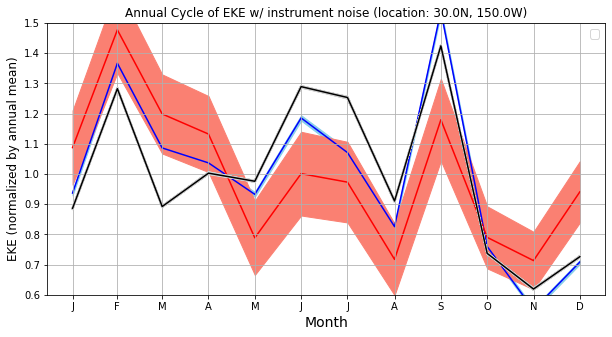

In [32]:
frac_year = np.nan*np.ones(len(s_i))
for i in range(len(s_i)):
    frac_year[i] = np.nanmean(s_i[i])
month_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

in_lon = []
in_lat = []
in_lon.append(np.where((lon_bin_c > location[l_i][0]) & (lon_bin_c < location[l_i][1]))[0])
in_lat.append(np.where((lat_bin_c > location[l_i][2]) & (lat_bin_c < location[l_i][3]))[0])

to_show = np.where((coarsening_factors == 3) | (coarsening_factors == 7) | (coarsening_factors == 15) |(coarsening_factors == 25))[0]
lsty = np.flip(['-', '--', '-.', '-.'])
f, ax = plt.subplots(1,1,figsize=(10,5))
cc = ['k', 'g', 'b', 'r']
cmc = ['#D3D3D3', 'g', '#87CEEB', '#FA8072']
# monte-carlo smallest scale 
i = 0 #(300km)
test0 = np.nan * np.ones((mc_runs, len(frac_year)))
for mc in range(mc_runs):
    ax.plot(frac_year, np.nanmean(mean_diff0_mc[:, in_lon[0]][:, :, in_lat[0]][:,:,:,to_show[i],mc],axis=tuple(range(1, 3)))/\
        np.nanmean(mean_diff0_mc[:, in_lon[0]][:, :, in_lat[0]][:,:,:,to_show[i]]), \
        color=cmc[0])
    test0[mc, :] = np.nanmean(mean_diff0_mc[:, in_lon[0]][:, :, in_lat[0]][:,:,:,to_show[i],mc],axis=tuple(range(1, 3)))/\
        np.nanmean(mean_diff0_mc[:, in_lon[0]][:, :, in_lat[0]][:,:,:,to_show[i]])
ax.fill_between(frac_year, np.nanmean(test0, axis=0) - np.nanstd(test0, axis=0), \
                np.nanmean(test0, axis=0) + np.nanstd(test0, axis=0), color=cmc[0], zorder=0)
ax.plot(frac_year, np.nanmean(test0, axis=0), color='k',zorder=2)
    
i = 1 #(140km)
test1 = np.nan * np.ones((mc_runs, len(frac_year)))
for mc in range(mc_runs):
    # ax.plot(frac_year, np.nanmean(mean_diff0_mc[:, in_lon[0]][:, :, in_lat[0]][:,:,:,to_show[i],mc],axis=tuple(range(1, 3)))/\
    #     np.nanmean(mean_diff0_mc[:, in_lon[0]][:, :, in_lat[0]][:,:,:,to_show[i]]), \
    #     color=cmc[2])
    test1[mc, :] = np.nanmean(mean_diff0_mc[:, in_lon[0]][:, :, in_lat[0]][:,:,:,to_show[i],mc],axis=tuple(range(1, 3)))/\
        np.nanmean(mean_diff0_mc[:, in_lon[0]][:, :, in_lat[0]][:,:,:,to_show[i]])
ax.fill_between(frac_year, np.nanmean(test1, axis=0) - np.nanstd(test1, axis=0), \
                np.nanmean(test1, axis=0) + np.nanstd(test1, axis=0), color=cmc[2], zorder=0)
ax.plot(frac_year, np.nanmean(test1, axis=0), color='b',zorder=0)
    
i = 2 #(80km)
test2 = np.nan * np.ones((mc_runs, len(frac_year)))
for mc in range(mc_runs):
    test2[mc, :] = np.nanmean(mean_diff0_mc[:, in_lon[0]][:, :, in_lat[0]][:,:,:,to_show[i],mc],axis=tuple(range(1, 3)))/\
        np.nanmean(mean_diff0_mc[:, in_lon[0]][:, :, in_lat[0]][:,:,:,to_show[i]])
ax.fill_between(frac_year, np.nanmean(test2, axis=0) - np.nanstd(test2, axis=0), \
                np.nanmean(test2, axis=0) + np.nanstd(test2, axis=0), color=cmc[3], zorder=0)
ax.plot(frac_year, np.nanmean(test2, axis=0), color='r',zorder=0)

# for i in [0,1,2]:
#     # filtered with no noise 
#     ax.plot(frac_year, np.nanmean(mean_diff0[:, in_lon[0]][:, :, in_lat[0]][:,:,:,to_show[i]], axis=tuple(range(1, 3)))/\
#             np.nanmean(mean_diff0[:, in_lon[0]][:, :, in_lat[0]][:,:,:,to_show[i]]), \
#             color=cc[i], linestyle=lsty[i], label='EKE at <=' + str(coarsening_factors[to_show[i]]*hor_grid_spacing) + 'km')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=12)
ax.set_xticks(frac_year)
ax.set_xticklabels(month_labels)
ax.set_ylim([0.6, 1.5])
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('EKE (normalized by annual mean)', fontsize=12)
ax.set_title('Annual Cycle of EKE w/ instrument noise (location: ' + str(np.nanmean(location[l_i][2:])) + 'N, ' + str(np.nanmean(location[l_i][0:2])) + 'W)')
ax.grid()
plt.show()
f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/r2/added_site_errors/j2_sample_monte_carlo_error_nw_pac.jpg', dpi=400)

In [59]:
outputs = {'frac_year': frac_year, \
          '300km': test0, \
          '140km': test1, \
          '80km': test2, \
          }
pickle.dump(outputs, open('/Users/jakesteinberg/Documents/CPT/altimetry/' + \
                          this_sat + '_monte_carlo_error_l3.p', 'wb'))

In [340]:
str(coarsening_factors[to_show[i]]*hor_grid_spacing)

'80.0'

In [ ]:
'''
mean_sla_smooth_mc = np.nan * np.ones((len(s_i), mc_runs, len(coarsening_factors)))
mean_diff0_mc = np.nan * np.ones((len(s_i), mc_runs, len(coarsening_factors)))
countf = 0
filters_mc = {}
for mc in range(mc_runs):           # cycle through monte-carlo run
    for tt in range(len(s_i)):      # each month 
        for tib in range(len(ai)):  # each track
            # for each track that crosses through box, again find subset of grid points in box 
            inn2 = np.where((lon1[tib] > this_lon0) & (lon1[tib] < this_lon1) & \
                            (lat1[tib] > this_lat0) & (lat1[tib] < this_lat1) & \
                            (np.abs(lat1[tib]) > 5))[0]
            # time bin 
            this_time = np.mod(year_time1[tib], 1)
            time_in = np.where((this_time > s_i[tt, 0]) & (this_time < s_i[tt, 1]))[0]
            # loop over each filter scale (ORDER large to small)   
            if countf < 1:
                for ff in range(len(coarsening_factors)):  
                    falls_within_1 = vel_filt_1[ff][tib][time_in][:, inn2, mc]  # [time_in, in_box, mc]  filtered, w/ noise
                    filters_mc[coarsening_factors[ff]] = falls_within_1
                countf = countf + 1
            else:
                for ff in range(len(coarsening_factors)):  
                    falls_within_1 = vel_filt_1[ff][tib][time_in][:, inn2, mc]  # [time_in, in_box, mc]  filtered, w/ noise
                    filters_mc[coarsening_factors[ff]] = np.concatenate((filters_mc[coarsening_factors[ff]], \
                                                                      falls_within_1))
        # average in this lat/lon box 
        if countf > 0:  
            # ORDER = large to small 
            for cf in range(len(coarsening_factors)):
                # -- large scale (\overline{\eta}^2) (filtering of the quantity, then squaring)
                mean_sla_smooth_mc[tt,mc,cf] = np.nanmean(filters[coarsening_factors[cf]]**2)
                # - SHARP -- EKE w/o filtering the squared velocity 
                mean_diff0_mc[tt,mc,cf] = np.nanmean(sla_i**2 - filters[coarsening_factors[cf]]**2) 
'''

In [138]:
np.shape(filters_mc[coarsening_factors[ff]])

(18, 50, 200)

In [139]:
np.shape(falls_within_1)

(9, 21, 200)

In [140]:
np.shape(falls_within_0)

(9, 21)

In [133]:
np.shape(year_time1[tib])

(113,)

In [134]:
this_time

array([8.05251142e-01, 8.32417546e-01, 8.59583502e-01, 8.86749564e-01,
       9.13915517e-01, 9.41082033e-01, 9.68247338e-01, 9.95412638e-01,
       2.25793521e-02, 4.97450006e-02, 7.69111213e-02, 1.04077549e-01,
       1.31242721e-01, 1.58409544e-01, 1.85575704e-01, 2.12742043e-01,
       2.39908269e-01, 2.67074530e-01, 2.94240670e-01, 3.21406822e-01,
       3.48572747e-01, 3.75738983e-01, 4.02905308e-01, 4.30070460e-01,
       4.57237998e-01, 4.84404348e-01, 5.11571275e-01, 5.38735584e-01,
       5.65903608e-01, 5.93069890e-01, 6.20234571e-01, 6.47401847e-01,
       6.74568651e-01, 7.01734081e-01, 7.28900388e-01, 7.56066456e-01,
       7.83233246e-01, 8.10398981e-01, 8.37564822e-01, 8.64731137e-01,
       8.91897786e-01, 9.19063242e-01, 9.46229078e-01, 9.73394508e-01,
       5.60662777e-04, 2.77264953e-02, 5.48924829e-02, 8.20584359e-02,
       1.09224471e-01, 1.36390611e-01, 1.63556991e-01, 1.90722993e-01,
       2.17889423e-01, 2.45055338e-01, 2.72221711e-01, 2.99388234e-01,
      